In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load, Topos
from scipy.optimize import newton
from matplotlib import pyplot as plt
planets = load('de423.bsp')

In [2]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023, e_c = 0.175, e_sigma = 0.06, i_sigma = 12,\
                 amp_c = 75, amp_max = 155, amp_min = 0):
        self.size = size
        self.mjd = mjd
        self.lambda_N = 0
        self.a = self.gen_a()
        self.e = self.gen_e(e_c, e_sigma)
        self.i = self.gen_i(i_sigma)
        self.amp = self.gen_amp(amp_c, amp_max, amp_min)
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg(self.phi, self.M, self.node, self.lambda_N)
        self.H = self.gen_H()
        cut = self.e > 0
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]
        self.X, self.Y, self.Z = zip(*map(self.kep_to_xyz, self.a, self.e, self.i, self.arg, self.node, self.M))
        self.xyz_to_equa(self.X, self.Y, self.Z)
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self, e_c, e_sigma):
        return np.random.normal(loc=e_c, scale=e_sigma, size = self.size)
        
    def gen_i(self, i_sigma):
        return np.arcsin(np.random.rayleigh(scale = i_sigma * np.pi/180., size = self.size))
        
    def gen_amp(self, amp_c, amp_max, amp_min):
        return np.random.triangular(amp_min, amp_c, amp_max, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size)) 
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size) % (2*np.pi)
        
    def gen_arg(self, phi, M, node, lambda_N):
        return (0.5*phi - 1.5*M - node + lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the radius
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        X = np.array(X0) - x_earth
        Y = np.array(Y0) * np.cos(epsilon) + np.array(Z0) * np.sin(epsilon)  - y_earth
        Z = np.array(Y0) * np.sin(epsilon) - np.array(Z0) * np.cos(epsilon) - z_earth
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)

In [79]:
p = plutino(size = 2000, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0, i_sigma=12, e_c = 0.3)

(array([219., 197., 184., 216., 226., 160., 188., 200., 201., 209.]),
 array([39.25002286, 39.28995058, 39.3298783 , 39.36980602, 39.40973374,
        39.44966146, 39.48958918, 39.5295169 , 39.56944462, 39.60937234,
        39.64930006]),
 <a list of 10 Patch objects>)

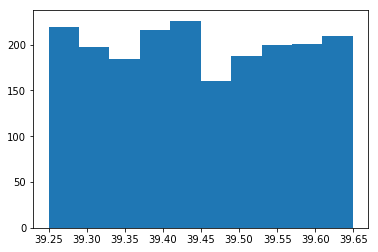

In [80]:
plt.hist(p.a)

(array([ 25.,  82., 224., 368., 483., 408., 250., 120.,  32.,   8.]),
 array([0.27192613, 0.27794993, 0.28397374, 0.28999754, 0.29602135,
        0.30204515, 0.30806896, 0.31409276, 0.32011657, 0.32614037,
        0.33216417]),
 <a list of 10 Patch objects>)

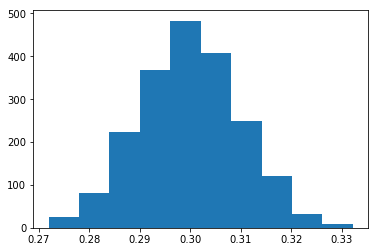

In [81]:
plt.hist(p.e)

(array([219., 489., 509., 362., 221., 117.,  55.,  16.,   9.,   3.]),
 array([ 0.46598865,  5.81651128, 11.16703392, 16.51755656, 21.86807919,
        27.21860183, 32.56912447, 37.9196471 , 43.27016974, 48.62069238,
        53.97121502]),
 <a list of 10 Patch objects>)

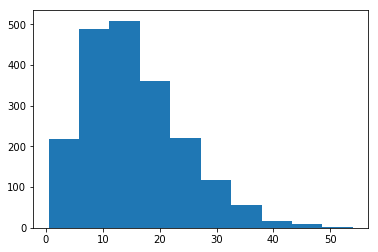

In [82]:
plt.hist(p.i*180/np.pi)

(array([   2.,    2.,    3.,   10.,   24.,   47.,  108.,  216.,  483.,
        1105.]),
 array([6.21609521, 6.59447756, 6.97285991, 7.35124227, 7.72962462,
        8.10800697, 8.48638932, 8.86477168, 9.24315403, 9.62153638,
        9.99991873]),
 <a list of 10 Patch objects>)

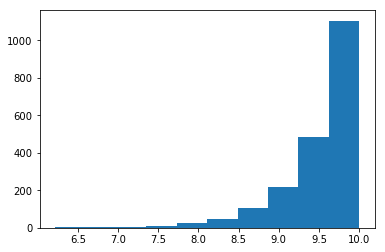

In [83]:
plt.hist(p.H)

(array([203., 199., 197., 187., 190., 192., 193., 223., 205., 211.]),
 array([4.55036846e-03, 1.25720951e+00, 2.50986865e+00, 3.76252779e+00,
        5.01518693e+00, 6.26784607e+00, 7.52050521e+00, 8.77316435e+00,
        1.00258235e+01, 1.12784826e+01, 1.25311418e+01]),
 <a list of 10 Patch objects>)

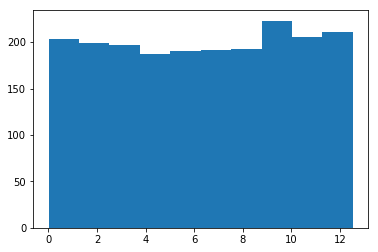

In [84]:
plt.hist(p.M)

(array([217., 206., 205., 170., 187., 215., 218., 202., 191., 189.]),
 array([7.09078993e-04, 6.28633642e-01, 1.25655820e+00, 1.88448277e+00,
        2.51240733e+00, 3.14033189e+00, 3.76825646e+00, 4.39618102e+00,
        5.02410558e+00, 5.65203014e+00, 6.27995471e+00]),
 <a list of 10 Patch objects>)

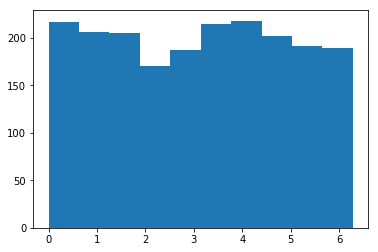

In [85]:
plt.hist(p.arg)

(array([164., 209., 200., 207., 211., 174., 205., 198., 224., 208.]),
 array([4.24344703e-03, 6.31623752e-01, 1.25900406e+00, 1.88638436e+00,
        2.51376467e+00, 3.14114497e+00, 3.76852528e+00, 4.39590558e+00,
        5.02328589e+00, 5.65066619e+00, 6.27804650e+00]),
 <a list of 10 Patch objects>)

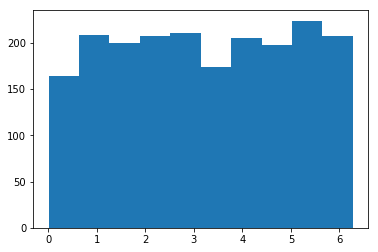

In [86]:
plt.hist(p.node)

(array([226., 178., 174., 196., 224., 194., 209., 190., 200., 209.]),
 array([3.72725518e-03, 6.30784813e-01, 1.25784237e+00, 1.88489993e+00,
        2.51195749e+00, 3.13901504e+00, 3.76607260e+00, 4.39313016e+00,
        5.02018772e+00, 5.64724528e+00, 6.27430283e+00]),
 <a list of 10 Patch objects>)

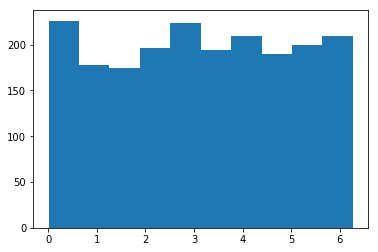

In [87]:
plt.hist((p.arg+p.node) % (2*np.pi))

(array([ 32., 113., 220., 301., 316., 338., 325., 235.,  93.,  27.]),
 array([3.10775507, 3.11451381, 3.12127254, 3.12803128, 3.13479001,
        3.14154875, 3.14830748, 3.15506622, 3.16182496, 3.16858369,
        3.17534243]),
 <a list of 10 Patch objects>)

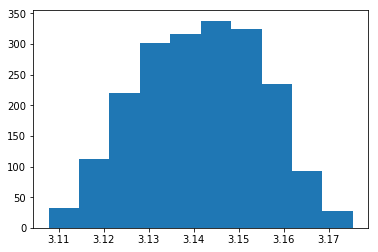

In [88]:
plt.hist(p.phi)

In [89]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [90]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

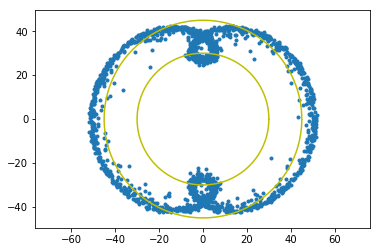

In [91]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')

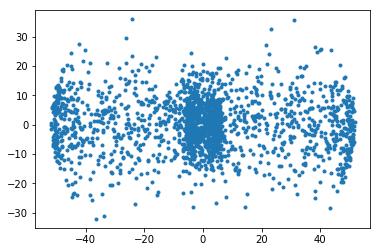

In [92]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

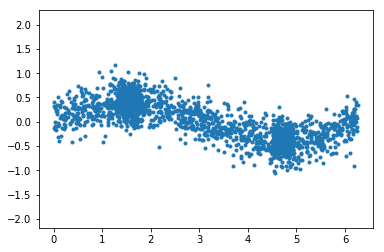

In [93]:
plt.axis('equal')
plt.scatter(p.ra,p.dec, marker = '.')